Enrico Convento -- id:2023572

Load the following files to avoid to re-run the training:


*   enc_basic
*   dec_basic
*   dec_gen
*   enc2
*   enc4
*   enc6
*   enc10
*   enc12
*   enc14
*   enc_opt
*   enc_best

And for the fine-tuning section:
* class1
* class2






# Autoencoder

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold

import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

from collections import OrderedDict
import ipywidgets as ipw

from sklearn.manifold import TSNE

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.
use_gpu = True

# Check if the GPU is available
device = torch.device("cuda") if (torch.cuda.is_available() and use_gpu) else torch.device("cpu")
if use_gpu:
  print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")
else:
  print(f'Training device: {device}')

Training device: cuda: Tesla K80


## Dataset

In [ ]:
### Download the data and create dataset
data_dir = 'dataset'
all_train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)
raw = True


In [4]:
class GetSample(Dataset):
  '''
  Creates a sample of the input dataset keeping also the transform
  Args:
    dataset: Dataset object
    index_list: list with the indexes of the objects to keep
  '''
  def __init__(self, dataset, index_list):
    self.transform = dataset.transform
    dataset.transform = None
    self.data = None
    try:
      self.data = [dataset[idx] for idx in index_list]
    except:
      print('Invalid index list')
      dataset.transform = self.transform
      raise IndexError
    dataset.transform = self.transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [ ]:
class ToTensor():
  '''
  Convert to tensor the image
  '''
  def __init__(self):
    self.t = transforms.ToTensor()

  def __call__(self, sample):
    pic, label = sample
    sample = (self.t(pic), label)
    return sample
class ReplaceLabel():
  '''
  (input, label) -> (input, input)
  '''
  def __call__(self, sample):
    pic, label = sample
    sample = (pic,pic)
    return sample


train_transform = transforms.Compose([
    transforms.ToTensor(),
    #ReplaceLabel()
])


## Dataset transormation

all_train_dataset.transform = train_transform
test_dataset.transform = train_transform


val_perc = 0.2
shuffle = False

train_dataset, val_dataset = train_test_split(all_train_dataset, test_size=val_perc, shuffle=shuffle)



print('Training data:', len(train_dataset), '\nValidation data:', len(val_dataset), '\nTest data: ', len(test_dataset))

In [ ]:
### TEST ###
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

## Encoder

In [7]:
class Encoder(nn.Module):
  '''
  Convolutional layers followed by linear layers

    Params of the convolutional layers: the following should be lists of int and be of the same lenght
      channels
      kernel_sizes
      strides
      paddings

    Params of the linear layers:
      Nhs: list of int: numbers of neurons per linear layer
      No: number of output neurons
    
    Activation functions:
      activation_function: default nn.ReLU (beware NOT nn.ReLU()): activation function between all the hidden layers
      o_act: default nn.Identity(): activation function after the output layer
  '''
  def __init__(self, channels=[], kernel_sizes=[], strides=[], paddings=[], Nhs=[], activation_function=nn.ReLU, No=10, o_act=nn.Identity()):
    super().__init__()
    self.No = No
    self.shapes = [(1, 28, 28)]

    ### Convolutional layer

    ## Create an ordered dictionary with the layers
    self.conv_od = OrderedDict([])
    for i,c in enumerate(channels):
      # add convolutional layer
      if i == 0:
        self.conv_od.update({'conv1': nn.Conv2d(in_channels=1,out_channels=channels[0],
                                                       kernel_size=kernel_sizes[0], stride = strides[0], padding=paddings[0])})
      else:
        self.conv_od.update({f'conv{i + 1}': nn.Conv2d(in_channels=channels[i - 1],out_channels=c,
                                                       kernel_size=kernel_sizes[i], stride = strides[i], padding=paddings[i])})
      next_size = (self.shapes[-1][1] + 2*paddings[i] - kernel_sizes[i])//strides[i] + 1
      self.shapes.append((c, next_size, next_size))
      if next_size < 1:
        raise TypeError(f'Shape flow interrupted: {self.shapes}')
      # add activation function
      self.conv_od.update({f'conv_act{i + 1}': activation_function()})

    ## Create a sequential layer
    self.conv_layers = nn.Sequential(self.conv_od)


    ### Flatten

    self.flatten = nn.Flatten(start_dim=1)
    self.shapes.append(np.product(self.shapes[-1]))


    ### Linear fc layers

    ## Create ordered dictionary with the layers
    self.lin_od = OrderedDict([])
    _Nhs = [self.shapes[-1]] + Nhs
    for i in range(1,len(_Nhs)):
      # add linear layer
      self.lin_od.update({f'lin{i}': nn.Linear(in_features=_Nhs[i - 1], out_features=_Nhs[i])})
      self.shapes.append(_Nhs[i])

      # add activation function
      self.lin_od.update({f'lin_act{i}': activation_function()})

    ## Create a sequential layer
    self.lin_layers = nn.Sequential(self.lin_od)


    ## Create the output layer
    self.out = nn.Linear(in_features=_Nhs[-1], out_features=No)
    self.o_act = o_act
    self.shapes.append(No)

    #print('Encoder initialized\nShape flow: ',self.shapes)

  def forward(self, x):
    # apply convolutional layers
    x = self.conv_layers(x)

    # flatten
    x = self.flatten(x)

    # apply linear layers
    x = self.lin_layers(x)

    # output layer
    x = self.o_act(self.out(x))
    return x

## Decoder

In [8]:
class Decoder(nn.Module):
  '''
  Linear layers followed by transposed convolutional layers

    Params of the linear layers:
      Ni: int: number of input neurons
      Nhs: list of int: numbers of neurons per linear layer, excluding the one before the unflattening: that one is computed automatically to match the shapes
    
    Params of the transposed convolutional layers: the following should be lists of int and be of the same lenght
      channels
      kernel_sizes
      strides
      paddings
      o_paddings: if left None (recommended) are automatically computed to match the shapes of an encoder with the same parameters of the decoder

    Activation functions:
      activation_function: default nn.ReLU (beware NOT nn.ReLU()): activation function between all the hidden layers
      o_act: default nn.Identity(): activation function after the output layer
  '''
  def __init__(self, Ni=10, Nhs=None, channels=None, kernel_sizes=None, strides=None, paddings=None, o_paddings=None,
               activation_function=nn.ReLU, o_shape=(1,28,28), o_act=nn.Identity()):
    super().__init__()

    # create the proper shapes:
    c_shapes = [o_shape] # go reversed through the convolutional channels to properly compute the shapes
    for j in range(len(channels)):
      i = len(channels) - j - 1
      next_size = next_size = (c_shapes[-1][1] + 2*paddings[i] - kernel_sizes[i])//strides[i] + 1
      c_shapes.append((channels[i], next_size, next_size))

    # compute the proper o_paddings if not provided
    if o_paddings is None:
      o_paddings = []
      for j in range(len(channels)):
        i = len(channels) - j - 1
        o_p = c_shapes[i][1] - ((c_shapes[i+1][1] - 1)*strides[j] - 2*paddings[j] + kernel_sizes[j])
        o_paddings.append(o_p)
      #Automatically setting output paddings 

    # check that the shapes match
    for j in range(len(channels)):
      i = len(channels) - j - 1
      next_size = (c_shapes[i+1][1] - 1)*strides[j] - 2*paddings[j] + kernel_sizes[j] + o_paddings[j]
      if next_size != c_shapes[i][1]:
        raise TypeError('Mismatched shapes: check output paddings, or better let them be computed automatically by not providing them')

    self.shapes = [Ni] + Nhs + [np.product(c_shapes[-1])]

    ### Linear fc layers

    ## Create ordered dictionary with the layers
    self.lin_od = OrderedDict([])
    for i in range(1,len(self.shapes)):
      # add activation function
      if i > 1:
        self.lin_od.update({f'lin_act{i}': activation_function()})
      # add linear layer
      self.lin_od.update({f'lin{i}': nn.Linear(in_features=self.shapes[i - 1], out_features=self.shapes[i])})

    ## Create a sequential layer
    self.lin_layers = nn.Sequential(self.lin_od)


    ### Unflatten
    s = c_shapes.pop(-1)
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=s)
    self.shapes.append(s)



    ### Convolutional layers
    _channels = channels + [o_shape[0]]

    ## Create an ordered dictionary with the layers
    self.conv_od = OrderedDict([])
    for i,c in enumerate(_channels[:-1]):
      # add activation function
      self.conv_od.update({f'conv_act{i + 1}': activation_function()})
      # add convolutional layer
      self.conv_od.update({f'conv{i + 1}': nn.ConvTranspose2d(in_channels=c,out_channels=_channels[i+1],kernel_size=kernel_sizes[i],
                                                              stride = strides[i], padding=paddings[i], output_padding=o_paddings[i])})
      self.shapes.append(c_shapes.pop(-1))

    if len(c_shapes) > 0:
      raise IndexError('Something went wrong in adapting the shapes')

    ## Create a sequential layer
    self.conv_layers = nn.Sequential(self.conv_od)

    ## Create the output layer
    self.o_act = o_act

    #print('Decoder initialized\nShape flow: ',self.shapes)

  def forward(self, x):
    # apply linear layers
    x = self.lin_layers(x)
    # unflatten
    x = self.unflatten(x)
    # apply convolutional layers
    x = self.conv_layers(x)
    # output layer
    x = self.o_act(x)
    return x

In [9]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 4}

decoder_params = {'Ni': 4, 'Nhs': [16,128],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1]}

enc = Encoder(**encoder_params)
dec = Decoder(**decoder_params)

 ## Trainer

In [10]:
class Training(object):
  '''
  Class for training a sequence of networks. This class is a starting point: to do more advanced stuff one can define new classes inheriting from this one.

  Args:
    encoder
    decoder
    optimizer: needs to be already linked to the net
    loss_function
    train_dataset: training data
    train_dataset: validation data
  '''
  def __init__(self, encoder, decoder , optimizer=None, loss_function=None, train_dataset=None, val_dataset=None, train_batch_size=256, val_batch_size=256):
    self.encoder = encoder
    self.decoder = decoder
    
    self.encoded_space_dim = self.encoder.No  # Latent space dimension
    self.optimizer = optimizer
    self.loss_function = loss_function

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset

    # build dataloader
    if self.train_dataset is not None:
      self.train_dataloader = DataLoader(self.train_dataset, batch_size=train_batch_size, shuffle=True)
    else:
      self.train_dataloader = None
    if self.val_dataset is not None:
      self.val_dataloader = DataLoader(self.val_dataset, batch_size=val_batch_size, shuffle=False)
    else:
      self.val_dataloader = None

    self.train_loss_log = []
    self.val_loss_log = []

  

  def stop_learning(self,epoch_num):
    return False


  def train_epoch(self):

    train_loss= []
    # set nets in train mode
    # Set train mode for both the encoder and the decoder
    self.encoder.train()
    self.decoder.train()

    
    try:
      for image_batch, _ in self.train_dataloader:
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = self.encoder(image_batch)
        # Decode data
        decoded_data = self.decoder(encoded_data)
        # Evaluate loss
        loss = self.loss_function(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Save train loss for this batch

        #train_loss.append(loss.data)



    except KeyboardInterrupt:
      # free gpu memory
      del image_batch, encoded_data , decoded_data
      torch.cuda.empty_cache()
      raise KeyboardInterrupt

    # Save average train loss
    #train_loss = np.sum(train_loss)/len(self.train_dataset)

    # free gpu memory
    del image_batch, encoded_data , decoded_data
    torch.cuda.empty_cache()

    return loss.data

  def val_epoch(self):

    # set nets in train mode
    self.encoder.eval()
    self.decoder.eval()
    with torch.no_grad(): # Disable gradient tracking
      # Define the lists to store the outputs for each batch
      conc_out = []
      conc_label = []
      try:
        for image_batch, _  in self.val_dataloader:
          
          # Move data to device
          image_batch = image_batch.to(device)
          # Forward pass
          # Encode data
          encoded_data = self.encoder(image_batch)
          # Decode data
          decoded_data = self.decoder(encoded_data)
          # Append the network output and the original image to the lists
          conc_out.append(decoded_data.cpu())
          conc_label.append(image_batch.cpu())
          # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Compute loss
        loss = self.loss_function(conc_out, conc_label)
        # Save val loss for this batch
        #loss_batch = loss.detach().cpu().numpy()
        #val_loss.append(loss.data)

      except KeyboardInterrupt:
        del image_batch
        torch.cuda.empty_cache()
        raise KeyboardInterrupt
        
    # Save average validation loss
    #val_loss = np.sum(val_loss)/n_data

    # free gpu memory
    del image_batch
    torch.cuda.empty_cache()
    return loss.data

  def train(self,num_epochs,verbose=False, display_every = 10, plot_verbose = True):
    '''
    Args:
      num_epochs: int, number of epochs
      verbose: bool, toggle for printing the training and loss function, default false
     
    '''
    self.encoder.to(device)
    self.decoder.to(device)


    ### TRAINING LOOP
    for epoch_num in np.arange(num_epochs):
      try:
        if verbose:
          print('\nEPOCH %d/%d' % (epoch_num + 1, num_epochs))

        ### TRAIN
        train_loss = self.train_epoch()
        if verbose:
          print('\n\n\t TRAIN - EPOCH %d/%d - loss: %f\n\n' % (epoch_num + 1, num_epochs, train_loss))
          #print(f"AVERAGE TRAIN LOSS: {train_loss}")
        self.train_loss_log.append(train_loss)
        ### VALIDATION
        val_loss = self.val_epoch()
        if verbose:
          #print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
          print('\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch_num + 1, num_epochs, val_loss))
        self.val_loss_log.append(val_loss)

        ### Plot progress
        if plot_verbose:
          # Get the output of a specific image (the test image at index 0 in this case)
          img = test_dataset[0][0].unsqueeze(0).to(device)
          self.encoder.eval()
          self.decoder.eval()
          with torch.no_grad():
              rec_img  = self.decoder(self.encoder(img))
          # Plot the reconstructed image
          fig, axs = plt.subplots(1, 2, figsize=(12,6))
          axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[0].set_title('Original image')
          axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
          plt.tight_layout()
          plt.pause(0.1)
          # Save figures
          os.makedirs('autoencoder_progress_%d_features' % self.encoded_space_dim, exist_ok=True)
          fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (self.encoded_space_dim, epoch_num + 1))
          plt.show()
          plt.close()

  

        ### early stopping
        if self.stop_learning(epoch_num):
          break


      except KeyboardInterrupt:
        # move nets back to cpu
        self.encoder.cpu()
        self.decoder.cpu()
        raise KeyboardInterrupt

    # move nets back to cpu
    # move nets back to cpu
        self.encoder.cpu()
        self.decoder.cpu()
      
        

  def plot_losses(self,avg_size=1):
    '''
    Plots the behavior of the train and val losses and prints their average in the last 'avg_size' epochs
    Args:
      avg_size: int
    '''
    plt.figure(figsize=(12,8))
    plt.semilogy(self.train_loss_log, label='Training loss')
    plt.semilogy(self.val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()



  def test(self,test_dataset):
    '''
    Args:
      test_dataset: Dataset with data on which to perform the test
    '''
    test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)
    return self.val_epoch(test_dataloader)

In [11]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 8}

decoder_params = {'Ni': 8, 'Nhs': [16,128],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1]}

enc = Encoder(**encoder_params)
dec = Decoder(**decoder_params)


optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-3, weight_decay=1e-5)

train_batch_size = 256
val_batch_size = 256

loss_function = torch.nn.MSELoss()

trainer = Training(enc, dec,optimizer,loss_function=loss_function,
                 train_dataset=train_dataset, val_dataset=val_dataset,
                 train_batch_size=train_batch_size, val_batch_size=val_batch_size)

In [ ]:
#trainer.train(50, verbose=True)
#trainer.plot_losses()


In [ ]:
#torch.save(enc.state_dict(), 'enc.pth')
#torch.save(dec.state_dict(), 'dec.pth')

### Visualize reconstrutions
In this case the basic AE has been used.

In [ ]:
import torchvision.utils

# Load network parameters
enc.load_state_dict(torch.load('enc_basic.pth'))
dec.load_state_dict(torch.load('dec_basic.pth'))
enc.to(device)
dec.to(device)
enc.eval()
dec.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, encoder, decoder):

    with torch.no_grad():
    
        images = images.to(device)
        images  = decoder(encoder(images))
        #images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.figure(figsize=(20,10))
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

test_dataloader = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False)
images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
imagegrid = torchvision.utils.make_grid(images[1:50],10,5)
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(imagegrid, (1, 2, 0)))
plt.show()

# Reconstruct and visualise the images using the vae
print('AE reconstruction:')
#plt.figure(figsize=(10,10))
visualise_output(images, enc, dec)

## Explore advanced optimizers and regularization

### Encoded space visualization

In [13]:
# Load network parameters
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 8}
encoder = Encoder(**encoder_params)
encoder.load_state_dict(torch.load('enc_basic.pth'))

<All keys matched successfully>

In [14]:
import plotly.express as px
def get_encoded_data(encoder, dataset):
  '''
  Creates a dataframe with the outputs of the encoder

  Args:
    enc: encoder
    dataset

  Returns:
    pd.DataFrame with columns ['latent var 0', 'latent var 1', ..., 'label'] 
  '''
  ### Get the encoded representation of the test samples
  encoded_samples = []
  encoder.to(device)
  for sample in tqdm(test_dataset):
      img = sample[0].unsqueeze(0).to(device)
      label = sample[1]
      # Encode image
      encoder.eval()
      with torch.no_grad():
          encoded_img  = encoder(img)
      # Append to list
      encoded_img = encoded_img.flatten().cpu().numpy()
      encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
      encoded_sample['label'] = label
      encoded_samples.append(encoded_sample)
  # Convert to a dataframe

  return pd.DataFrame(encoded_samples)

def plot_slice(encoded_samples, label_names):
  '''
  Scatters a 2d slice of a dataframe

  Args:
    df: dataframe produced by 'get_encoded_data'
  '''
  fig = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
  fig.show(renderer='colab')



 

In [15]:
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
df = get_encoded_data(encoder, test_dataset)
plot_slice(df, label_names)

100%|██████████| 10000/10000 [00:18<00:00, 539.48it/s]


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = pca.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice(reduced_df, label_names)

In [ ]:
tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)
plot_slice(reduced_df, label_names)

### Generate samples from the encoded space

In [ ]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 2}

decoder_params = {'Ni': 2, 'Nhs': [16,128],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1]}

enc = Encoder(**encoder_params)
dec = Decoder(**decoder_params)


optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-3, weight_decay=1e-5)

train_batch_size = 256
val_batch_size = 256

loss_function = torch.nn.MSELoss()

trainer = Training(enc, dec,optimizer,loss_function=loss_function,
                 train_dataset=train_dataset, val_dataset=val_dataset,
                 train_batch_size=train_batch_size, val_batch_size=val_batch_size)
trainer.train(10)

In [ ]:
#torch.save(enc.state_dict(), 'enc_gen.pth')
#torch.save(dec.state_dict(), 'dec_gen.pth')

In [ ]:
#Load network parameters
dec.load_state_dict(torch.load('dec_gen.pth'))
# load a network that was trained with a 2d latent space

    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,2,20)
    latent_y = np.linspace(-1.5,2,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = dec(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(15, 15))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,10))
    plt.show()

### Early stopping

In [21]:
class Training_es(Training):

  def __init__(self, patience, *args, **kwargs):
    '''
    *** Training with early stopping ***
    Args:
      patience: int: if after patience epochs the validation loss does not decrease learning stops

      *args, **kwargs: arguments of the parent class
    '''
    super().__init__(*args, **kwargs)

    self.patience = patience
    self.counter = 0
    self.best_vl = 10


  def stop_learning(self,epoch_num):
    if epoch_num <= self.patience: # at least do 'patience' epochs
      return False

    if self.val_loss_log[-1] < self.best_vl:
      self.best_vl = self.val_loss_log[-1]
      self.counter =0

    else:
      self.counter += 1

    if self.counter >= self.patience:
      print('---> Early stopping')
      return True

In [22]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 8}

decoder_params = {'Ni': 8, 'Nhs': [16,128],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1]}

enc = Encoder(**encoder_params)
dec = Decoder(**decoder_params)


optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-3, weight_decay=1e-5)


loss_function = torch.nn.MSELoss()


params = {'encoder': enc, 'decoder':dec , 'optimizer': optimizer, 'loss_function':loss_function,
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 256, 'val_batch_size': 512}

additional_params = {'patience': 16 }

trainer = Training_es(**params, **additional_params)


In [ ]:
## Training ##
#trainer.train(50, verbose=True, plot_verbose = True)
#trainer.plot_losses()

### Pruning

In [23]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 8}

decoder_params = {'Ni': 8, 'Nhs': [16,128],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1]}

enc = Encoder(**encoder_params)
dec = Decoder(**decoder_params)


optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-3, weight_decay=1e-5)


params = {'encoder': enc, 'decoder':dec , 'optimizer': optimizer, 'loss_function': torch.nn.MSELoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 256, 'val_batch_size': 512}

additional_params = {'patience': 2}

trainer = Training_es(**params, **additional_params)


In [24]:
from torch.nn.utils import prune

parameters_to_prune_lin = (
    (dec.lin_layers.lin1, 'weight'),
    (dec.lin_layers.lin2, 'weight'),
    (dec.lin_layers.lin3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune_lin,
    pruning_method=prune.L1Unstructured,
    amount=0.8
)

parameters_to_prune_conv = (
    (dec.conv_layers.conv1, 'weight'),
    (dec.conv_layers.conv2, 'weight'),
    (dec.conv_layers.conv3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune_conv,
    pruning_method=prune.L1Unstructured,
    amount=0.3
)

In [ ]:
## Training ##


parameters_to_prune_el = [(child, 'weight') for child in enc.lin_layers.children() if isinstance(child, nn.Linear)]
parameters_to_prune_ec = [(child, 'weight') for child in enc.conv_layers.children() if isinstance(child, nn.Conv2d)]
parameters_to_prune_dl = [(child, 'weight') for child in dec.lin_layers.children() if isinstance(child, nn.Linear)]
parameters_to_prune_dc = [(child, 'weight') for child in dec.conv_layers.children() if isinstance(child, nn.ConvTranspose2d)]

prune_every = 5
enc_lin_amount = 0.1
enc_conv_amount = 0.06
dec_lin_amount = 0.1
dec_conv_amount = 0.06

n_epochs_th = 0

while n_epochs_th == len(trainer.val_loss_log):
  if n_epochs_th != 0:
    print('Pruning')
    prune.global_unstructured(parameters_to_prune_el, pruning_method=prune.L1Unstructured, amount=enc_lin_amount)
    prune.global_unstructured(parameters_to_prune_ec, pruning_method=prune.L1Unstructured, amount=enc_conv_amount)
    prune.global_unstructured(parameters_to_prune_dl, pruning_method=prune.L1Unstructured, amount=dec_lin_amount)
    prune.global_unstructured(parameters_to_prune_dc, pruning_method=prune.L1Unstructured, amount=dec_conv_amount)

    for t in (parameters_to_prune_el + parameters_to_prune_ec + parameters_to_prune_dl + parameters_to_prune_dc):
      prune.remove(*t)

  trainer.train(prune_every,verbose=True)
  n_epochs_th += prune_every

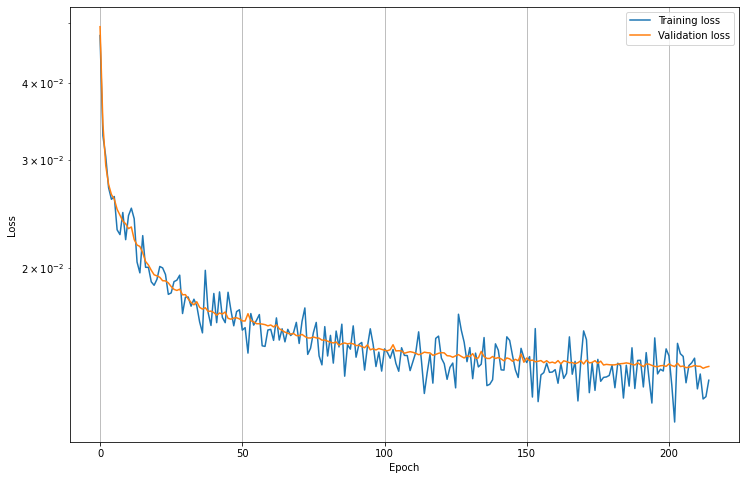

In [ ]:
#trainer.plot_losses()

### Dropout

In [25]:
class Encoder_d(Encoder):
  '''
  Adds a dropout layer before every hidden linear layer with dropout probability given by 'dropout_probabilities'
  '''
  def __init__(self,*args, dropout_probabilities=None, **kwargs):
    super().__init__(*args,**kwargs)

    if dropout_probabilities is not None:
      self.d_od = OrderedDict()
      i = 0
      for k,l in self.lin_od.items():
        if not k.startswith('lin_act') and i < len(dropout_probabilities):
          self.d_od.update({f'dropout{i+1}': nn.Dropout(dropout_probabilities[i])})
          i += 1
        self.d_od.update({k: l})

      self.lin_layers = nn.Sequential(self.d_od)

class Decoder_d(Decoder):
  '''
  Adds a dropout layer after every hidden linear layer with dropout probability given by 'dropout_probabilities'
  '''
  def __init__(self,*args, dropout_probabilities=None, **kwargs):
    super().__init__(*args,**kwargs)

    if dropout_probabilities is not None:
      self.d_od = OrderedDict()
      i = 0
      for k,l in self.lin_od.items():
        self.d_od.update({k: l})
        if not k.startswith('lin_act') and i < len(dropout_probabilities):
          self.d_od.update({f'dropout{i+1}': nn.Dropout(dropout_probabilities[i])})
          i += 1

      self.lin_layers = nn.Sequential(self.d_od)

In [26]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 4, 'dropout_probabilities': [0.5,0.5]}

decoder_params = {'Ni': 4, 'Nhs': [16,128], 'dropout_probabilities': [0., 0., 0.],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1],
                  'o_act': nn.Identity()}

enc = Encoder_d(**encoder_params)
dec = Decoder_d(**decoder_params)


optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-3, weight_decay=1e-5)



params = {'encoder': enc, 'decoder':dec , 'optimizer': optimizer, 'loss_function': torch.nn.MSELoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 256, 'val_batch_size': 512}

additional_params = {'patience': 10}

trainer = Training_es(**params, **additional_params)



In [ ]:
#trainer.train(50,verbose=True, plot_verbose = False)

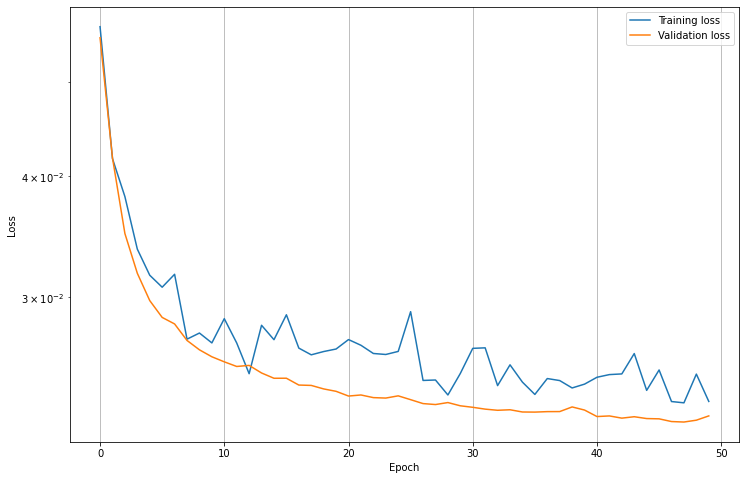

In [ ]:
#trainer.plot_losses()

## Encoded space


In [27]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'dropout_probabilities': [0.5,0.5]}

decoder_params = { 'Nhs': [16,128], 'dropout_probabilities': [0., 0., 0.],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1],
                  'o_act': nn.Identity()}

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

In [ ]:
## Run this cell if you want to re-perform the training, otherwise load the weights

for encoded_dim in range(2, 16, 2):
  print('Encoded dimension : ', encoded_dim)
  encoder_params['No'] = encoded_dim
  decoder_params['Ni'] = encoded_dim
  enc = Encoder_d(**encoder_params)
  dec = Decoder_d(**decoder_params)

  optimizer = optim.Adam([
                      {'params': enc.parameters()},
                      {'params': dec.parameters()}
                      ], lr=1e-3, weight_decay=1e-5)


  loss_function = torch.nn.MSELoss()
  train_batch_size = 256
  val_batch_size = 256

  params = {'encoder': enc, 'decoder':dec , 'optimizer': optimizer, 'loss_function': torch.nn.BCEWithLogitsLoss(),
                'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 256, 'val_batch_size': 512}

  additional_params = {'patience': 2, 'best_val_loss' : 0.3}

  trainer = Training_es(**params, **additional_params)
  trainer.train(50,verbose=False, plot_verbose = False)
  print('Final training loss : ', trainer.train_loss_log[-1].item())
  print('Final validation loss : ', trainer.val_loss_log[-1].item())

  # 
  
  torch.save(enc.state_dict(), 'enc'+ str(encoded_dim) +'.pth')
  torch.save(dec.state_dict(), 'dec'+ str(encoded_dim) +'.pth')


In [ ]:
encoder_params['No'] = 2

# Load network parameters
encoder = Encoder_d(**encoder_params)
encoder.load_state_dict(torch.load('enc2.pth'))
df = get_encoded_data(encoder, test_dataset)


tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice(reduced_df, label_names)

In [ ]:
encoder_params['No'] = 4

# Load network parameters
encoder = Encoder_d(**encoder_params)
encoder.load_state_dict(torch.load('enc4.pth'))
df = get_encoded_data(encoder, test_dataset)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice(reduced_df, label_names)

In [ ]:
encoder_params['No'] = 6

# Load network parameters
encoder = Encoder_d(**encoder_params)
encoder.load_state_dict(torch.load('enc6.pth'))
df = get_encoded_data(encoder, test_dataset)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice(reduced_df, label_names)

In [ ]:
encoder_params['No'] = 10

# Load network parameters
encoder = Encoder_d(**encoder_params)
encoder.load_state_dict(torch.load('enc10.pth'))
df = get_encoded_data(encoder, test_dataset)


tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice(reduced_df, label_names)

In [ ]:
encoder_params['No'] = 12

# Load network parameters
encoder = Encoder_d(**encoder_params)
encoder.load_state_dict(torch.load('enc12.pth'))
df = get_encoded_data(encoder, test_dataset)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice(reduced_df, label_names)

In [ ]:
encoder_params['No'] = 14

# Load network parameters
encoder = Encoder_d(**encoder_params)
encoder.load_state_dict(torch.load('enc14.pth'))
df = get_encoded_data(encoder, test_dataset)


tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice(reduced_df, label_names)

## Optuna optimization

In [ ]:
!pip install optuna

In [35]:
import optuna

In [38]:
k = 5


name = 'AE -- optimization'



optimizer_type = optim.Adam

loss_function = nn.MSELoss()

trainer_type = Training_es

# add a time penalty as regularizer
time_penalty = 1e-5

latent_space_penalty = 1e-2

def objective(trial):


  # sample hypermarameters
  
  # convolutional layers part
  n_c_layers = trial.suggest_int('ncl', 2, 4)
  
  channels = []
  kernel_sizes = []
  strides = []
  paddings = []

  for j in range(n_c_layers):
    channels.append(trial.suggest_int(f'ch{j+1}', 4, 8*2**j))
    kernel_sizes.append(trial.suggest_int(f'ks{j+1}', 2, 6))
    strides.append(trial.suggest_int(f'stride{j+1}', 1, 4))
    paddings.append(trial.suggest_int(f'padding{j+1}', 0, kernel_sizes[-1]//2))


  # linear layers part
  n_l_layers = trial.suggest_int('nll', 1, 3)

  Nhs = []
  ps = []

  for j in range(n_l_layers):
    Nhs.append(trial.suggest_int(f'Nh{j+1}', 8, 256/2**j, log=True))
    ps.append(trial.suggest_float(f'p{j+1}', 0, 0.7))

  N_latent = trial.suggest_int('N_latent',1,16)

  # net params
  encoder_params = {'channels': channels.copy(), 'kernel_sizes': kernel_sizes.copy(), 'strides': strides.copy(), 'paddings': paddings.copy(),
                    'Nhs': Nhs.copy(), 'No': N_latent}
  

  channels.reverse()
  kernel_sizes.reverse()
  strides.reverse()
  paddings.reverse()
  Nhs.reverse()

  decoder_params = {'Ni': N_latent, 'Nhs': Nhs,
                  'channels': channels, 'kernel_sizes': kernel_sizes, 'strides': strides, 'paddings': paddings}
  


  
  # optimizer part
  lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
  weight_decay = trial.suggest_float('weight_decay', 1e-7,1e-1, log=True)
  
  
  # train_batch_size
  train_batch_size = trial.suggest_int('train_batch_size', 64, 512, log=True)

  # patience
  patience = trial.suggest_int('patience',4,16)

 

  trainer_additional_params = {'patience': patience}
  try:
    enc = Encoder(**encoder_params)
    dec = Decoder(**decoder_params)

    optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=lr, weight_decay=weight_decay)
    params = {'encoder': enc, 'decoder':dec , 'optimizer': optimizer, 'loss_function': torch.nn.MSELoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': train_batch_size, 'val_batch_size': 256}
    trainer = Training_es(**params, **trainer_additional_params)


    trainer.train(50, verbose = False, plot_verbose = False)

    avg_train_loss, avg_val_loss = trainer.train_loss_log[-1], trainer.val_loss_log[-1]
    print('\n\nResults')
    print(f'### Average train loss: {avg_train_loss}')
    print(f'### Average validation loss: {avg_val_loss}\n\n')
  except TypeError:
    raise optuna.TrialPruned() # to stop trials that produce invalid nets
  except KeyboardInterrupt: 
    raise KeyboardInterrupt
  
  hyper_dict = dict(**encoder_params, **{'lr': lr, 'weight_decay':weight_decay}, **trainer_additional_params,
                    **{'avg_tr_loss': avg_train_loss, 'avg_val_loss': avg_val_loss})


  return trainer.best_vl


study = optuna.create_study(study_name=name)

[I 2022-02-09 21:02:50,007] A new study created in memory with name: AE -- optimization


In [ ]:
## Uncomment if you want to re-perform the hyperparams study
##study.optimize(objective, n_trials=2)


In [ ]:
## Before run this cell you need to run the cell above

#trial = study.best_trial
## Best trial accuracy ##
#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

### Optimized net - Optuna

In [47]:

channels = [4,9,27,9]
kernel_sizes = [3,6,2,2]
strides = [2,2,2,2]
paddings = [1,2,1,1]

Nhs = [237]
N_latent = 16


encoder_params = {'channels': channels.copy(), 'kernel_sizes': kernel_sizes.copy(), 'strides': strides.copy(), 'paddings': paddings.copy(),
                  'Nhs': Nhs.copy(), 'No': N_latent}

channels.reverse()
kernel_sizes.reverse()
strides.reverse()
paddings.reverse()
Nhs.reverse()

decoder_params = {'Ni': N_latent, 'Nhs': Nhs,
                  'channels': channels, 'kernel_sizes': kernel_sizes, 'strides': strides, 'paddings': paddings}




enc = Encoder(**encoder_params)
dec = Decoder(**decoder_params)


optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-3, weight_decay=1e-2)


params = {'encoder': enc, 'decoder':dec , 'optimizer': optimizer, 'loss_function': torch.nn.MSELoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 114, 'val_batch_size': 256}

additional_params = {'patience': 13 }

trainer = Training_es(**params, **additional_params)

In [ ]:
## Run this cell only if you want to re-perfrom the training otherwise the 
## file enc.opt will be loaded in the next cell

trainer.train(50, verbose=False, plot_verbose = False)
trainer.plot_losses()

In [49]:
#torch.save(enc.state_dict(), 'enc_opt.pth')
channels = [4,9,27,9]
kernel_sizes = [3,6,2,2]
strides = [2,2,2,2]
paddings = [1,2,1,1]

Nhs = [237]
N_latent = 16
# Load network parameters
encoder_params = {'channels': [4,9,27,9], 'kernel_sizes': [3,6,2,2], 'strides': [2,2,2,2], 'paddings': [1,2,1,1],
                  'Nhs': [237], 'No': 16}
enc = Encoder(**encoder_params)
enc.load_state_dict(torch.load('enc_opt.pth')) ## Load weights

<All keys matched successfully>

In [ ]:
df = get_encoded_data(enc, test_dataset)
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice(reduced_df, label_names)

### Optimized net - Manual tuning

In [44]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 8, 'dropout_probabilities': [0.3,0.3]}

decoder_params = {'Ni': 8, 'Nhs': [16,128], 'dropout_probabilities': [0.1, 0.1, 0.1],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1],
                  'o_act': nn.Sigmoid()}

enc = Encoder_d(**encoder_params)
dec = Decoder_d(**decoder_params)


optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-3, weight_decay=1e-5)



params = {'encoder': enc, 'decoder':dec , 'optimizer': optimizer, 'loss_function': torch.nn.MSELoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 256, 'val_batch_size': 512}

additional_params = {'patience': 10}

trainer = Training_es(**params, **additional_params)

In [ ]:
#trainer.train(50,verbose=False, plot_verbose = False)

---> Early stopping


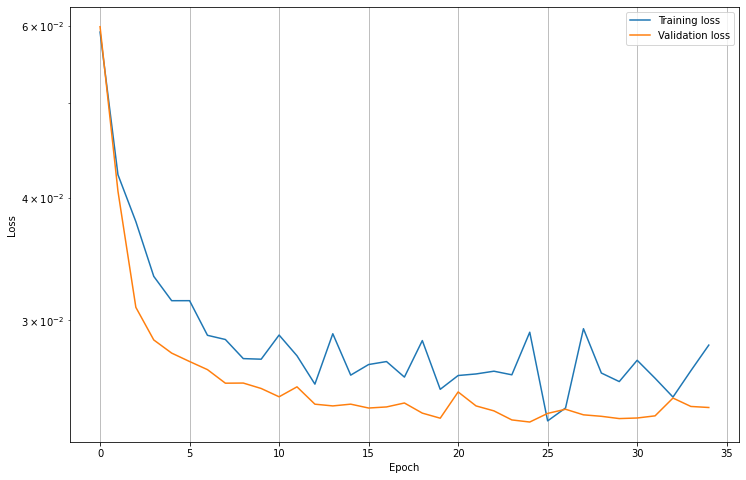

In [ ]:
#trainer.plot_losses()

In [45]:
#torch.save(enc.state_dict(), 'enc_best.pth')
#torch.save(dec.state_dict(), 'dec_best.pth')

# Load network parameters
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 8, 'dropout_probabilities': [0.3,0.3]}
enc = Encoder_d(**encoder_params)
enc.load_state_dict(torch.load('enc_best.pth'))

<All keys matched successfully>

In [ ]:
df = get_encoded_data(enc, test_dataset)
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'Enc. Variable {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice(reduced_df, label_names)

## Fine-Tuning

In [51]:
class FCN(nn.Module):
  def __init__(self, Ni, Nhs=None, No=10, activation_function=nn.ReLU, o_act=nn.Identity()):
    '''
    Fully connencted network

    Args:
      Ni: input neurons
      Nhs: list of neurons of the hidden layers
      No: output neurons
      activation_function: default nn.ReLU (beware not nn.ReLU() !!)
      o_act: activation function after the output layer, default nn.Identity()
    '''
    super().__init__()

    self.od = OrderedDict({})
    self.shapes = [Ni]
    if Nhs is not None and len(Nhs) > 0:
      self.shapes += Nhs

    for i,s in enumerate(self.shapes[:-1]):
      self.od.update({f'lin{i+1}': nn.Linear(s, self.shapes[i+1])})
      self.od.update({f'lin_act{i+1}': activation_function()})
    
    self.od.update({'out': nn.Linear(self.shapes[-1], No)})
    self.shapes.append(No)

    self.lin_layers = nn.Sequential(self.od)

    self.o_act = o_act


  def forward(self, x):
    x = self.o_act(self.lin_layers(x))
    return x


In [52]:
# Load network parameters
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 8}
encoder = Encoder(**encoder_params)
encoder.load_state_dict(torch.load('enc_basic.pth'))
print(enc)

for param_name, param in encoder.named_parameters():
    param.requires_grad = False 
    


Encoder(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act1): ReLU()
    (conv2): Conv2d(4, 9, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (conv_act2): ReLU()
    (conv3): Conv2d(9, 27, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv_act3): ReLU()
    (conv4): Conv2d(27, 9, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv_act4): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (lin1): Linear(in_features=81, out_features=237, bias=True)
    (lin_act1): ReLU()
  )
  (out): Linear(in_features=237, out_features=16, bias=True)
  (o_act): Identity()
)


### Solution 1

In [65]:
classifier_params = {'Ni': 8, 'Nhs': [64,288], 'No': 10}
classifier = FCN(**classifier_params)

In [66]:
classifier

FCN(
  (lin_layers): Sequential(
    (lin1): Linear(in_features=8, out_features=64, bias=True)
    (lin_act1): ReLU()
    (lin2): Linear(in_features=64, out_features=288, bias=True)
    (lin_act2): ReLU()
    (out): Linear(in_features=288, out_features=10, bias=True)
  )
  (o_act): Identity()
)

In [67]:
class Training_FT(Training):
 
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def train_epoch(self):

    train_loss= []
    # set nets in train mode
    # Set train mode for both the encoder and the decoder
    self.encoder.train()
    self.decoder.train()

    
    try:
      for image_batch, label_batch in self.train_dataloader:
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        self.encoder.zero_grad()
        self.decoder.zero_grad()
        # Encode data
        encoded_data = self.encoder(image_batch)
        # Decode data
        decoded_data = self.decoder(encoded_data)
        # Evaluate loss
        loss = self.loss_function(decoded_data, label_batch)
        # Backward pass
        
        loss.backward()
        self.optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)



    except KeyboardInterrupt:
      # free gpu memory
      del image_batch, encoded_data , decoded_data ,label_batch
      torch.cuda.empty_cache()
      raise KeyboardInterrupt

    # Save average train loss
    #train_loss = np.sum(train_loss)/len(self.train_dataset)

    # free gpu memory
    del image_batch, encoded_data , decoded_data, label_batch
    torch.cuda.empty_cache()

    return np.mean(train_loss)

  def val_epoch(self):
    
    val_loss = []
    # set nets in train mode
    self.encoder.eval()
    self.decoder.eval()
    with torch.no_grad(): # Disable gradient tracking
      # Define the lists to store the outputs for each batch
      conc_out = []
      conc_label = []
      try:
        for image_batch, label_batch  in self.val_dataloader:
          
          # Move data to device
          image_batch = image_batch.to(device)
          label_batch = label_batch.to(device)
          # Forward pass
          # Encode data
          encoded_data = self.encoder(image_batch)
          # Decode data
          decoded_data = self.decoder(encoded_data)
          # Append the network output and the original image to the lists
          conc_out.append(decoded_data.cpu())
          conc_label.append(label_batch.cpu())
          # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Compute loss
        loss = self.loss_function(conc_out, conc_label)
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

      except KeyboardInterrupt:
        del image_batch
        torch.cuda.empty_cache()
        raise KeyboardInterrupt
        


    # free gpu memory
    del image_batch
    torch.cuda.empty_cache()
    
    return np.mean(val_loss)

In [ ]:
optimizer = torch.optim.Adam([
                        {'params': encoder.parameters()},
                        {'params': classifier.parameters()}
                       ], lr=2e-3, weight_decay=1e-4)

train_batch_size = 256
val_batch_size = 256

loss_function = nn.CrossEntropyLoss()

trainer = Training_FT(encoder, classifier,optimizer,loss_function=loss_function,
                 train_dataset=train_dataset, val_dataset=val_dataset,
                 train_batch_size=train_batch_size, val_batch_size=val_batch_size)
# Check if correct
for param_name, param in trainer.encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))
# Check if correct

for param_name, param in trainer.decoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

In [ ]:
#trainer.train(50, verbose=True, plot_verbose = False)
#trainer.plot_losses()

In [69]:
#torch.save(trainer.decoder.state_dict(), 'class1.pth')

#Load network parameters
classifier.load_state_dict(torch.load('class1.pth'))
trainer.decoder = classifier

In [ ]:
from sklearn import metrics
import seaborn as sn

test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)

net_outputs = np.array([])
labels = np.array([])

trainer.encoder.eval()
trainer.decoder.eval()
with torch.no_grad():
  for batch in test_dataloader:
    out = torch.argmax(trainer.decoder(trainer.encoder(batch[0])), dim=1).cpu().numpy()

    label = batch[1].cpu().numpy()
    
    

    net_outputs = np.concatenate([net_outputs, out])
    labels = np.concatenate([labels, label])

net_outputs = np.array(net_outputs, dtype=int)
labels = np.array(labels, dtype=int)
cm = metrics.confusion_matrix(labels, net_outputs)
# Show the confusion matrix
fig = plt.figure(figsize=(10,8))
sn.heatmap(cm/np.sum(cm)*10, annot=True, cmap='rocket_r')
accuracy = np.mean(net_outputs == labels)

print('Network accuracy:', accuracy)


### Solution 2

In [59]:
classifier_params = {'Ni': 8, 'No': 10}
classifier = FCN(**classifier_params)

In [60]:
classifier


FCN(
  (lin_layers): Sequential(
    (out): Linear(in_features=8, out_features=10, bias=True)
  )
  (o_act): Identity()
)

In [ ]:
# Load network parameters
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 8}
encoder = Encoder(**encoder_params)
encoder.load_state_dict(torch.load('enc_basic.pth'))
print(enc)

for param_name, param in encoder.named_parameters():
    param.requires_grad = False 

optimizer = torch.optim.Adam([
                        {'params': encoder.parameters()},
                        {'params': classifier.parameters()}
                       ], lr=2e-3, weight_decay=1e-4)

train_batch_size = 256
val_batch_size = 256

loss_function = nn.CrossEntropyLoss()

trainer = Training_FT(encoder, classifier,optimizer,loss_function=loss_function,
                 train_dataset=train_dataset, val_dataset=val_dataset,
                 train_batch_size=train_batch_size, val_batch_size=val_batch_size)
# Check if correct
for param_name, param in trainer.encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))
# Check if correct

for param_name, param in trainer.decoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))


In [ ]:
#trainer.train(50, verbose=True, plot_verbose = False)
#trainer.plot_losses()

In [62]:
#torch.save(trainer.decoder.state_dict(), 'class2.pth')

#Load network parameters
classifier.load_state_dict(torch.load('class2.pth'))
trainer.decoder = classifier

In [ ]:
net_outputs = np.array([])
labels = np.array([])

trainer.encoder.eval()
trainer.decoder.eval()
with torch.no_grad():
  for batch in test_dataloader:
    out = torch.argmax(trainer.decoder(trainer.encoder(batch[0])), dim=1).cpu().numpy()

    label = batch[1].cpu().numpy()
    
    

    net_outputs = np.concatenate([net_outputs, out])
    labels = np.concatenate([labels, label])

net_outputs = np.array(net_outputs, dtype=int)
labels = np.array(labels, dtype=int)
cm = metrics.confusion_matrix(labels, net_outputs)
# Show the confusion matrix
fig = plt.figure(figsize=(10,8))
sn.heatmap(cm/np.sum(cm)*10, annot=True, cmap='rocket_r')
accuracy = np.mean(net_outputs == labels)

print('Network accuracy:', accuracy)
